**House Prices: Advanced Regression Techniques Based On Ensemble Learning**

**Le Bao Phuc**


# Import libraries

In [27]:
# Essentials
import numpy as np
import pandas as pd
import random
import os
import pickle

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

# Models
from sklearn.ensemble import GradientBoostingRegressor,VotingRegressor,StackingRegressor, RandomForestRegressor
from sklearn.linear_model import Ridge, RidgeCV,Lasso
# from sklearn.linear_model import ElasticNet
# from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor




# Misc
from sklearn.model_selection import KFold, cross_val_score,train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

from scipy.stats import skew, norm

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Load data
First we need to load our data from Google Drive and then extract it. Then we load training set and test set

In [28]:
# from google.colab import drive
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials
# drive.mount('/content/drive')

In [29]:
# dic = "./drive/MyDrive/"
# house=os.path.join(dic,"house-prices-advanced-regression-techniques.zip")
# !cp $house "/content"
# !unzip -o "/content/house-prices-advanced-regression-techniques.zip" -d "/content/"

In [30]:
train=pd.read_csv("./train.csv")
test=pd.read_csv("./test.csv")
train.shape,test.shape

((1460, 81), (1459, 80))

They also provide us with a data description file which we can use to view the description of our data.

In [31]:
!cat ./data_description.txt -q

'cat' is not recognized as an internal or external command,
operable program or batch file.


# Exploratory data analysis
View some rows of our data

In [32]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Analysis SalePrice

SalePrice is what we need to predict. Let's see its distribution.


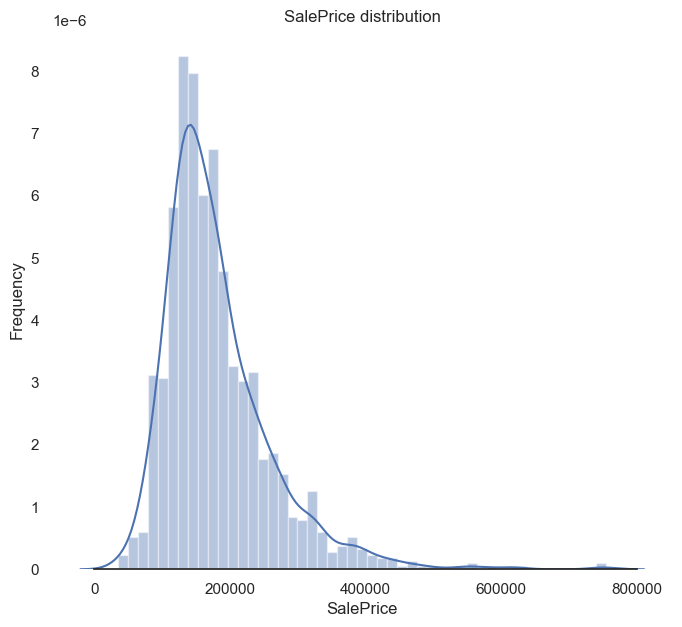

In [33]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.distplot(train['SalePrice'], color="b");
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)
plt.show()

As we can see, The salePrice deviated from a normal distribution. It's also right skewed. This was expected as few people can afford very expensive houses. We can check its Skewness by using skew and kurt.

In [34]:
# Skew and kurt
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


Having high skewness is not good, therefore we will come back and transform our sale price later.

# Correlation matrix

Now we shall draw the correlation matrix to have a quick overview of our data and its relationships. We shall pay more attention to the SalePrice feature since it's what we are trying to predict.

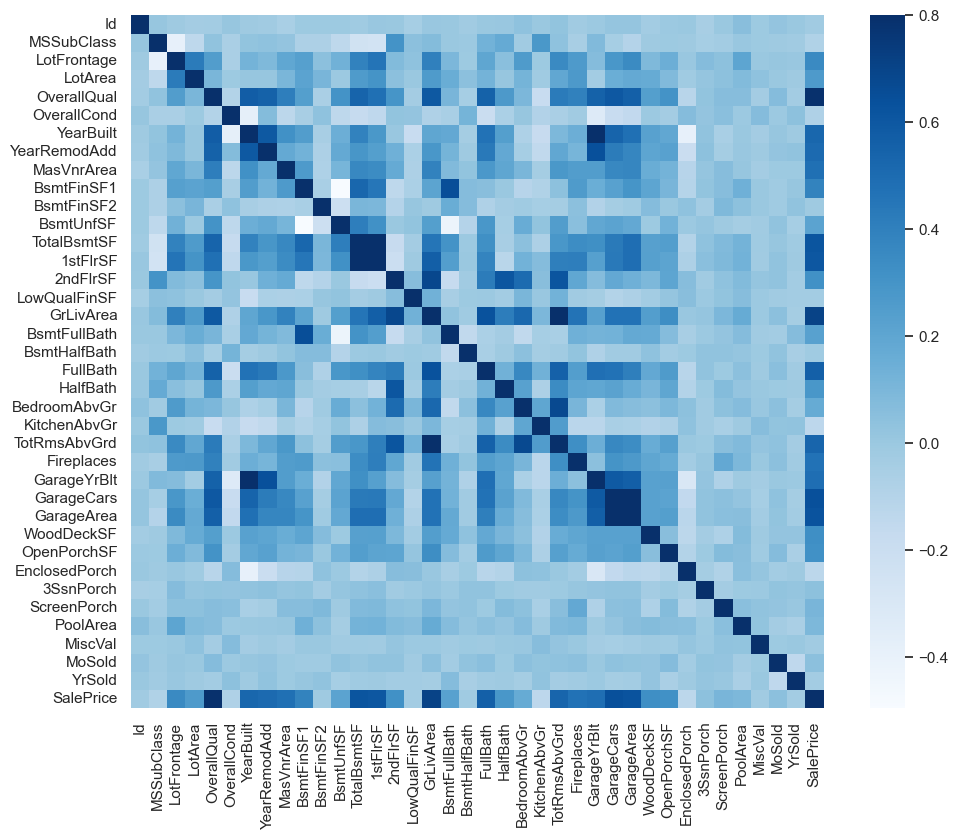

In [36]:
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8,square=True,xticklabels=True, yticklabels=True,cmap="Blues");

Some darker squares got our attention like OverallQual, GrLivArea, TotalBsmtSF,... This correlation can means bigger houses usually have higher prices. There are also many more dark squares that we need to pay attention to.
We will plot some relationships between SalePrice and some other features.

<AxesSubplot: >

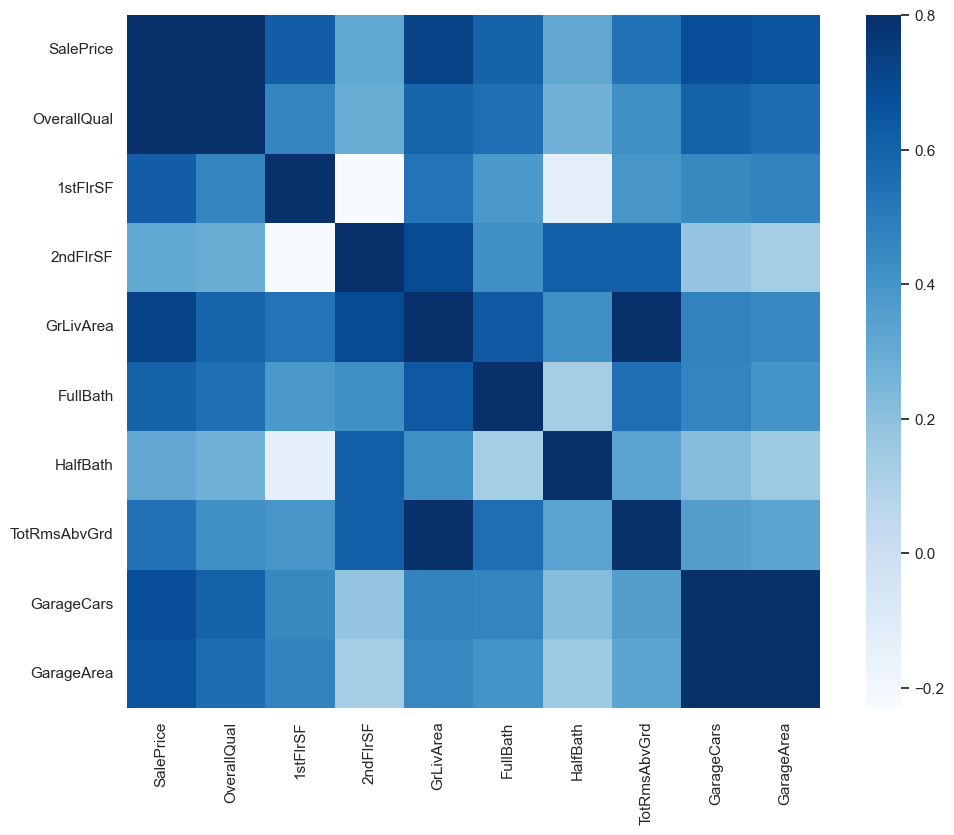

In [100]:
dfcol = train[['SalePrice','OverallQual','1stFlrSF','2ndFlrSF','GrLivArea','FullBath','HalfBath','TotRmsAbvGrd','GarageCars','GarageArea']]
corrcol = dfcol.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrcol, vmax=.8,square=True,xticklabels=True, yticklabels=True,cmap="Blues")

some special feature correlate with saleprice

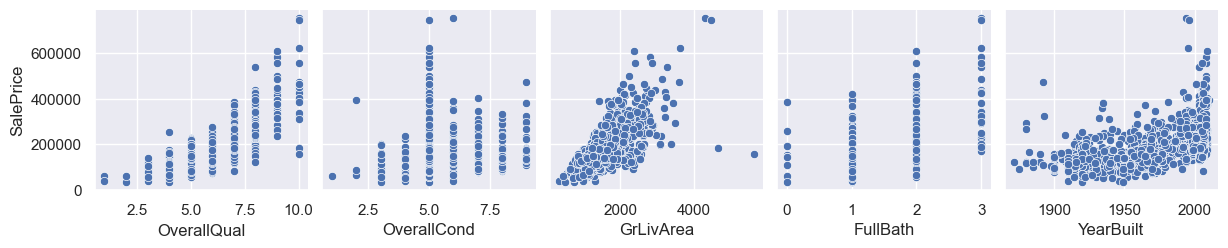

In [37]:
sns.set()
cols = [ 'OverallQual','OverallCond', 'GrLivArea', 'FullBath', 'YearBuilt']
sns.pairplot(train,y_vars='SalePrice',size=2.5,x_vars=cols)
plt.show();

We can see that most higher-quality houses have a higher prices. Having 3 bathrooms also increase the cost. GrLiveArea proportion with the SalePrice as well with 2 outliers. 

We shall plot more feature correlation:

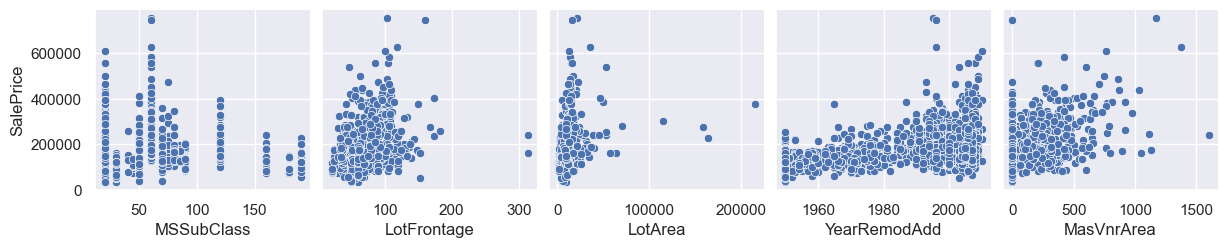

In [38]:
sns.set()
cols = ['MSSubClass','LotFrontage','LotArea','YearRemodAdd','MasVnrArea']
sns.pairplot(train,y_vars='SalePrice',size=2.5,x_vars=cols)
plt.show();

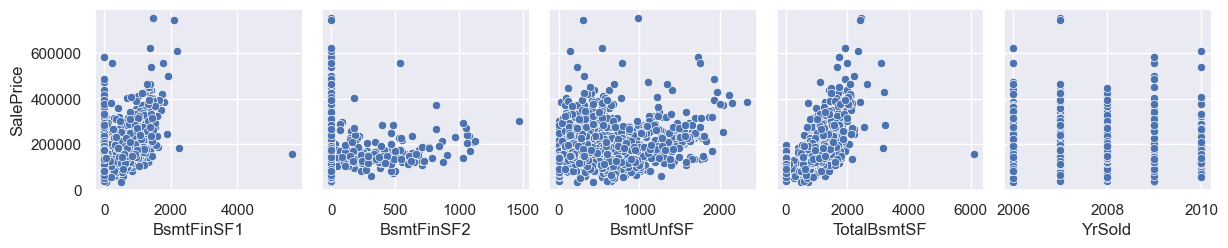

In [39]:
sns.set()
cols = ['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','YrSold']
sns.pairplot(train,y_vars='SalePrice',size=2.5,x_vars=cols)
plt.show();

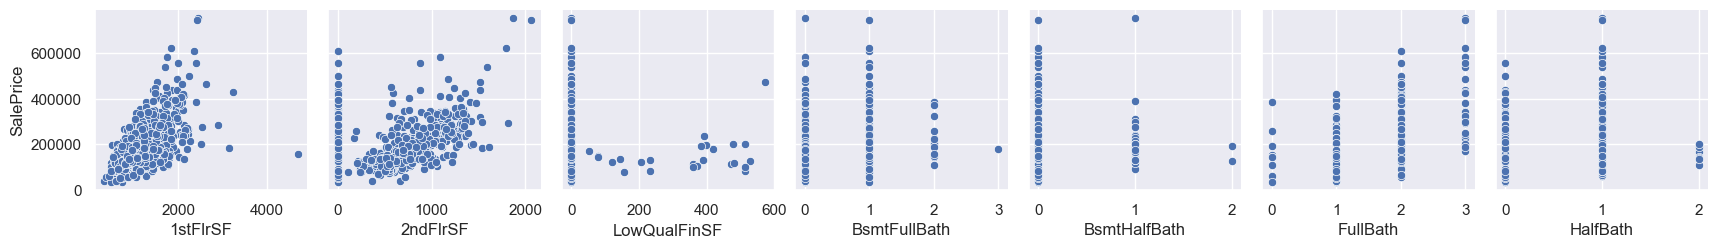

In [40]:
sns.set()
cols = ['1stFlrSF','2ndFlrSF','LowQualFinSF','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath']
sns.pairplot(train,y_vars='SalePrice',size=2.5,x_vars=cols)
plt.show();

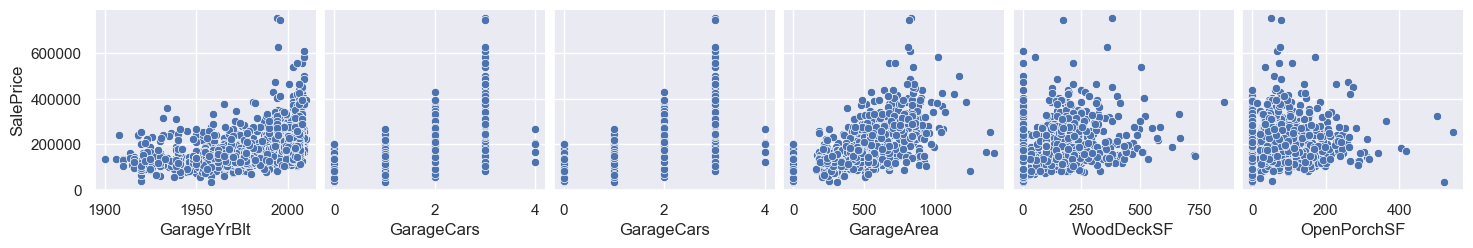

In [41]:
sns.set()
cols = ['GarageYrBlt','GarageCars','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF']
sns.pairplot(train,y_vars='SalePrice',size=2.5,x_vars=cols)
plt.show();

As we can see, many features have a correlation with SalePrice and can be used to predict the SalePrice. By plotting this, we can detect some outliers as well.

# Feature engineering

First we need to fix the skewness in our SalePrice by using log transformation.

In [42]:
train["SalePrice"] = np.log1p(train["SalePrice"])

After transforming, we can check the distribution again and compare it with the normal distribution


 mu = 12.02 and sigma = 0.40



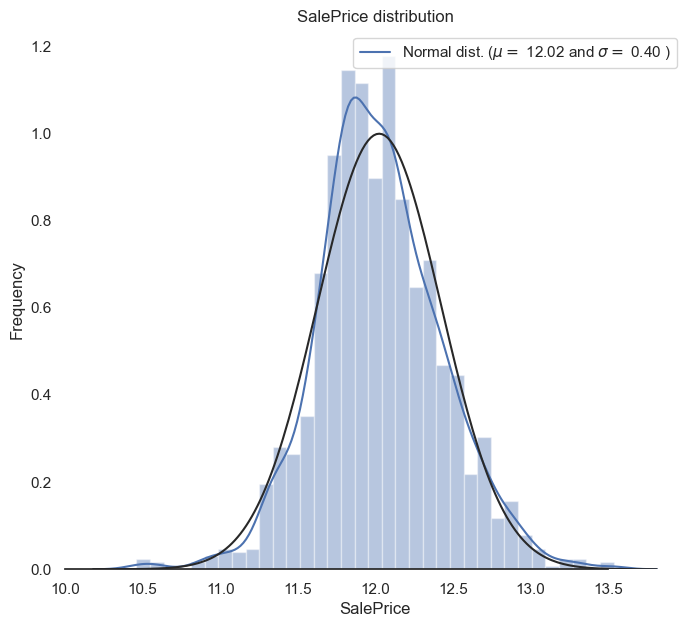

In [43]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.distplot(train['SalePrice'] , fit=norm, color="b");

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)

plt.show()

We can also remove outliers we found before when plotting.

In [44]:
train.drop(train[(train['OverallQual']<5) & (train['SalePrice']>200000)].index, inplace=True)
train.drop(train[(train['OverallCond']<3) & (train['SalePrice']>300000)].index, inplace=True)
train.drop(train[(train['BsmtFinSF1']>4500) & (train['SalePrice']<200000)].index, inplace=True)
train.drop(train[(train['TotalBsmtSF']>6000) & (train['SalePrice']<200000)].index, inplace=True)
train.drop(train[(train['1stFlrSF']>4000) & (train['SalePrice']<200000)].index, inplace=True)
train.drop(train[(train['GrLivArea']>4500) & (train['SalePrice']<300000)].index, inplace=True)
train.reset_index(drop=True, inplace=True)

In [45]:
# Split features and labels
train_labels = train['SalePrice'].reset_index(drop=True)
train_features = train.drop(['SalePrice'], axis=1)
test_features = test

# Combine train and test features in order to apply the feature transformation pipeline to the entire dataset
all_features = pd.concat([train_features, test_features]).reset_index(drop=True)
all_features.shape

(2917, 80)

# Missing data

Now we need to check for missing data and develop our filling strategy.

In [46]:
total = all_features.isnull().sum().sort_values(ascending=False)
percent = (all_features.isnull().sum()/all_features.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data[missing_data.Total>0]

,Total,Percent
PoolQC,2908,0.996915
MiscFeature,2812,0.964004
Alley,2719,0.932122
Fence,2346,0.804251
FireplaceQu,1420,0.486802
LotFrontage,486,0.166610
GarageYrBlt,159,0.054508
GarageFinish,159,0.054508
GarageQual,159,0.054508
GarageCond,159,0.054508


## Filling missing values

There are many missing values in the dataset. Each feature can have its own filling strategy depend on the data type as well as the meaning. For example, missing PoolQC data doesn't imply that the data is missing, it's implied that the house doesn't have a pool.

We will fill these missing categorical features with the string 'None' imply that the house doesn't 't have that feature.

In [47]:
# Filling missing data with none
fill_with_none=['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
                'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                'PoolQC','MiscFeature','Alley','Fence','FireplaceQu','MasVnrType']
for col in fill_with_none:
  all_features[col] = all_features[col].fillna('None')

Now we will fill missing numeric value with the number 0.

In [48]:
# Fill missing numeric feature with 0
fill_with_zero=['GarageYrBlt','GarageCars','GarageArea','BsmtFinSF2','TotalBsmtSF','BsmtUnfSF','MasVnrArea',
                'BsmtHalfBath','BsmtFullBath','BsmtFinSF1']
for col in fill_with_zero:
  all_features[col] = all_features[col].fillna(0)

We can use some extra information to fill in the missing data for `LotFrontage` and `MSZoning`. The intuition behind this is that the `LotFrontage` size of the house is probably close to the neighborhood. Same for `MSZoning`.

In [49]:
# Filling missing LotFrontage with median of Neighborhood's LotFrontage
all_features['LotFrontage'] = all_features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
# Filling missing MSZoning with mode of the same MSSubClass
all_features['MSZoning']=all_features.groupby('MSSubClass')['MSZoning'].transform(lambda x:x.fillna(x.mode()[0]))

In case we forgot any columns, we will fill the rest

In [50]:
# Fill the rest
for i in all_features.columns:
  if all_features[i].dtype=='O':
    all_features[i]=all_features[i].fillna(all_features[i].mode()[0])

Rechecking to make sure that we have no more missing data.

In [51]:
#Re check missing data
total = all_features.isnull().sum().sort_values(ascending=False)
percent = (all_features.isnull().sum()/all_features.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data[missing_data.Total>0]

,Total,Percent


# Fix skewed feature

In [52]:
# Convert MSSubClass to string
all_features['MSSubClass']=all_features['MSSubClass'].astype('str')

Skewed features are bad. We shall check the skewness for all of our numeric features.

In [53]:
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

skew_features = all_features.select_dtypes(numeric_dtypes).apply(lambda x: skew(x)).sort_values(ascending=False)
skew_features=skew_features[skew_features>0.75]
skew_features

MiscVal          21.939672
PoolArea         17.688664
LotArea          13.109495
LowQualFinSF     12.084539
3SsnPorch        11.372080
KitchenAbvGr      4.300550
BsmtFinSF2        4.144503
EnclosedPorch     4.002344
ScreenPorch       3.945101
BsmtHalfBath      3.929996
MasVnrArea        2.621719
OpenPorchSF       2.529358
WoodDeckSF        1.844792
1stFlrSF          1.257286
LotFrontage       1.103039
GrLivArea         1.068750
BsmtFinSF1        0.980645
BsmtUnfSF         0.919688
2ndFlrSF          0.861556
dtype: float64

As we can see, some features are highly skewed. Let's plot some of them

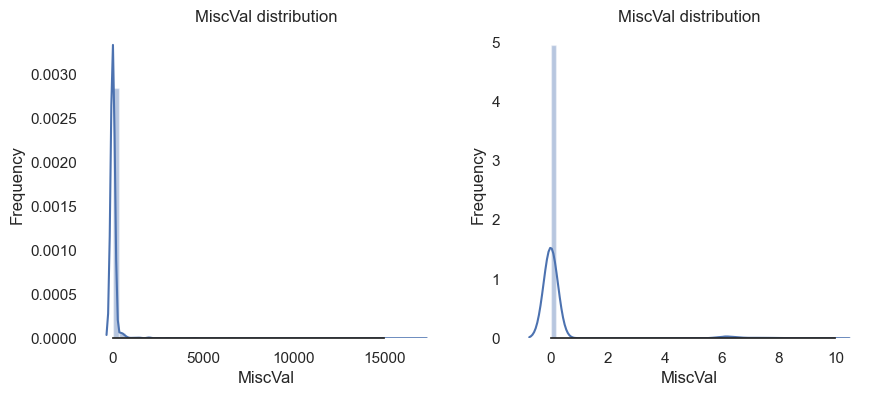

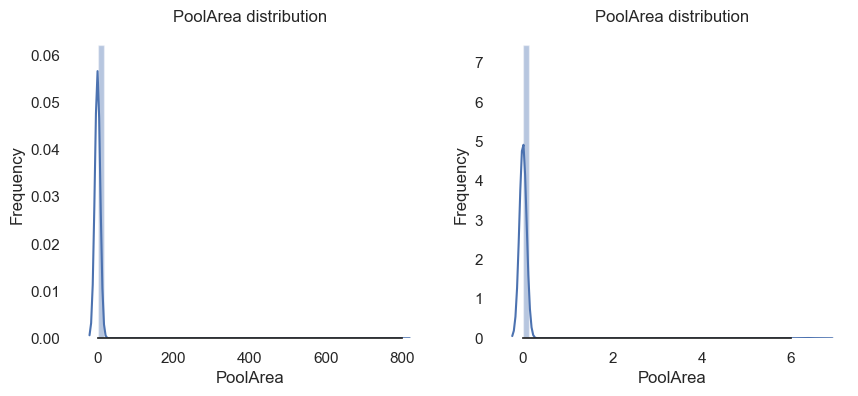

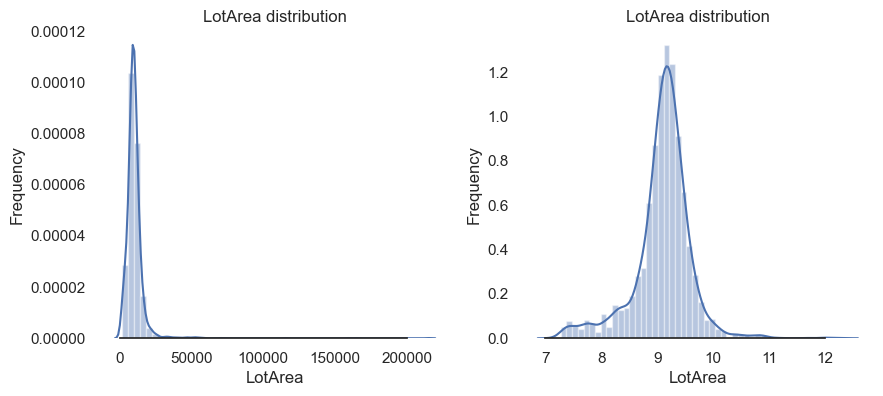

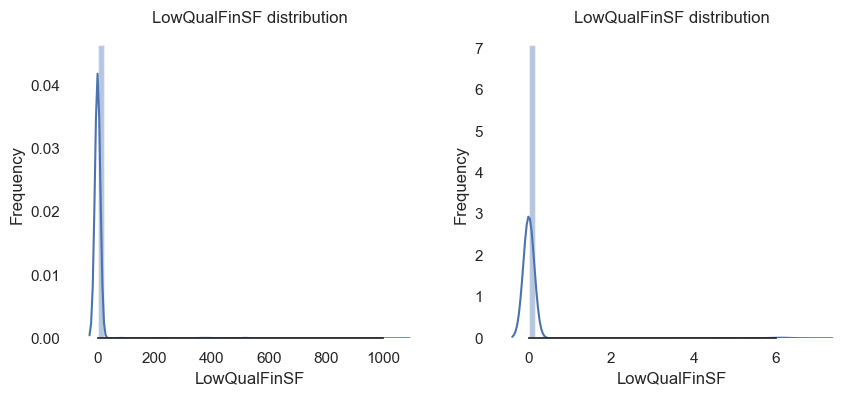

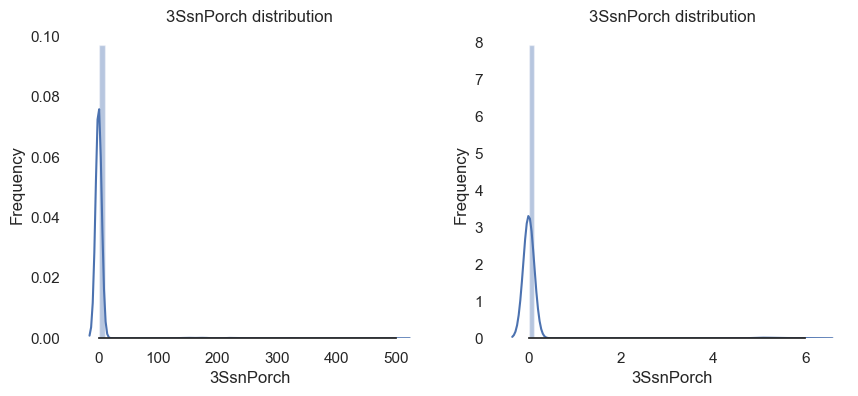

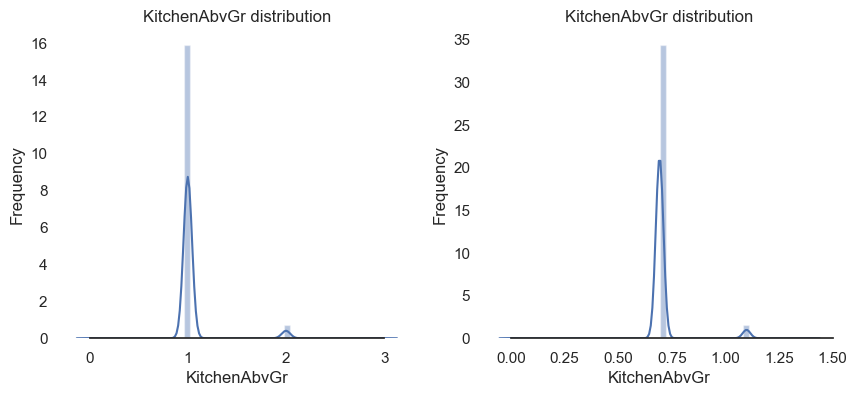

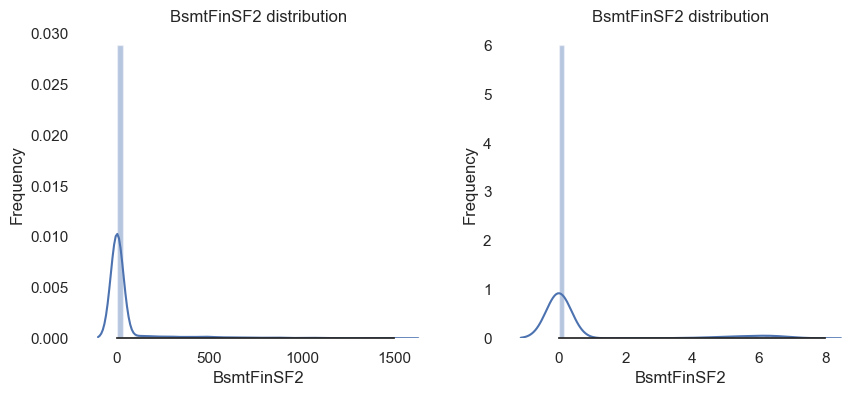

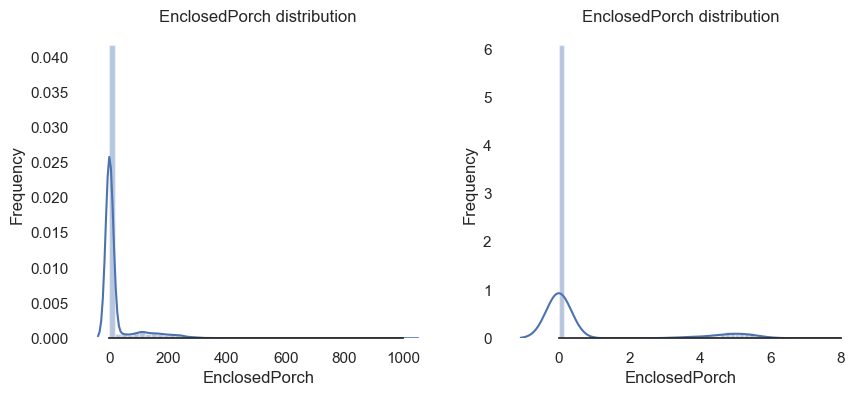

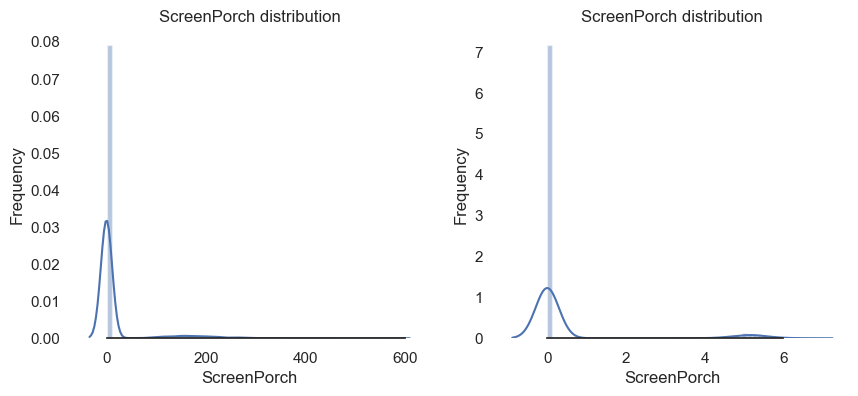

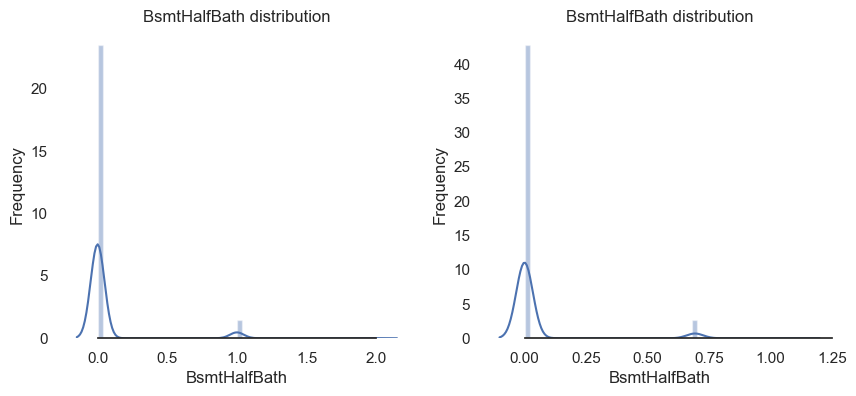

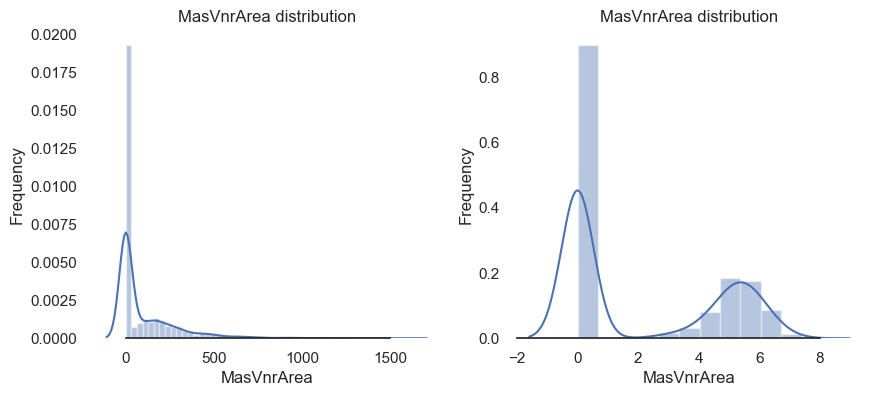

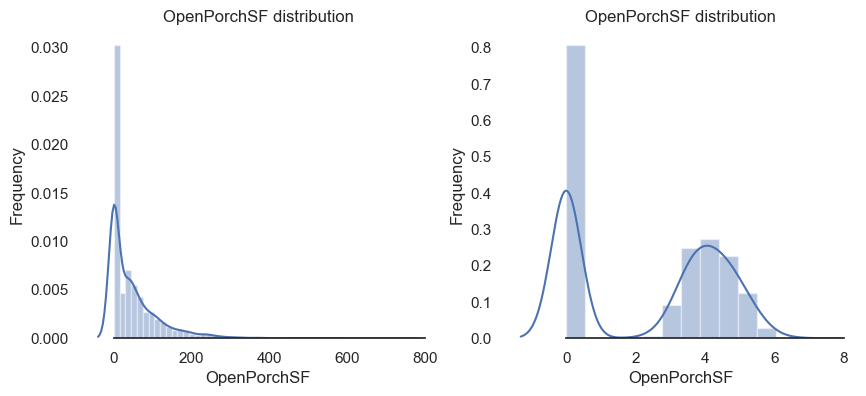

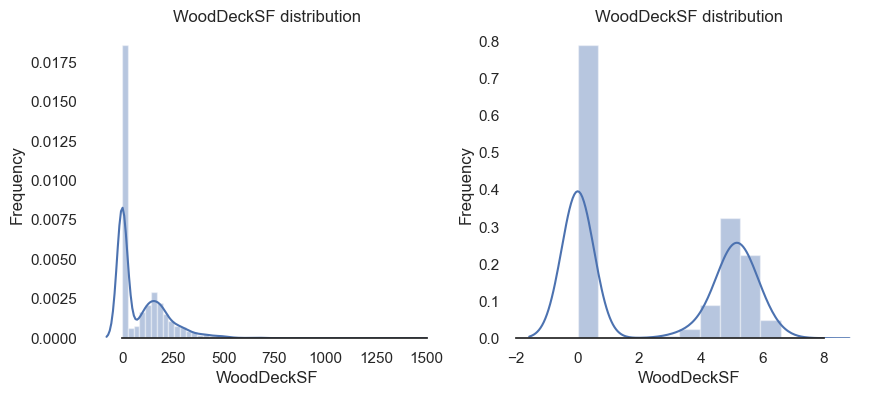

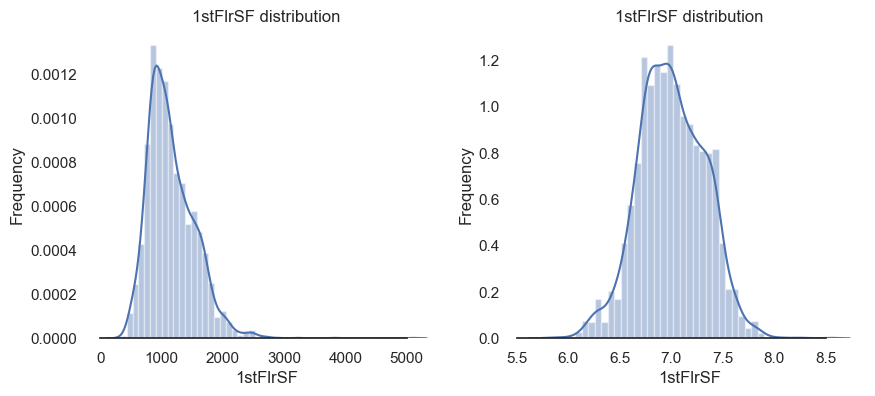

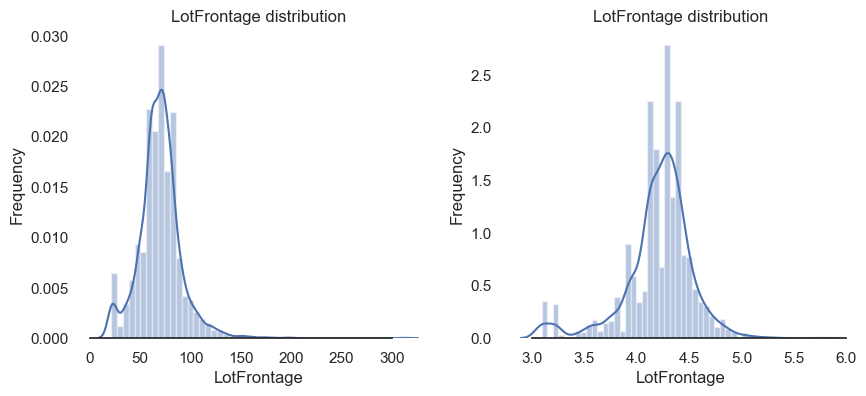

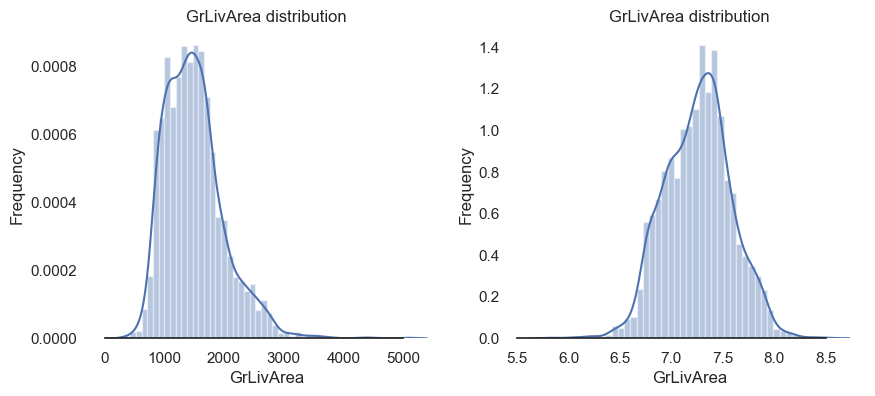

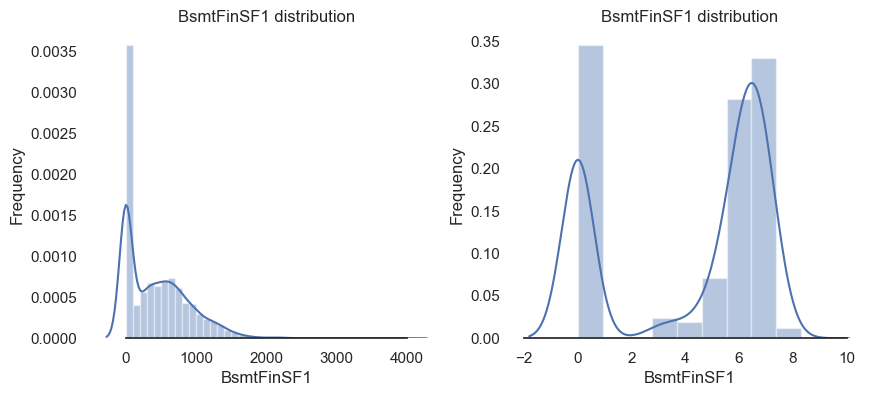

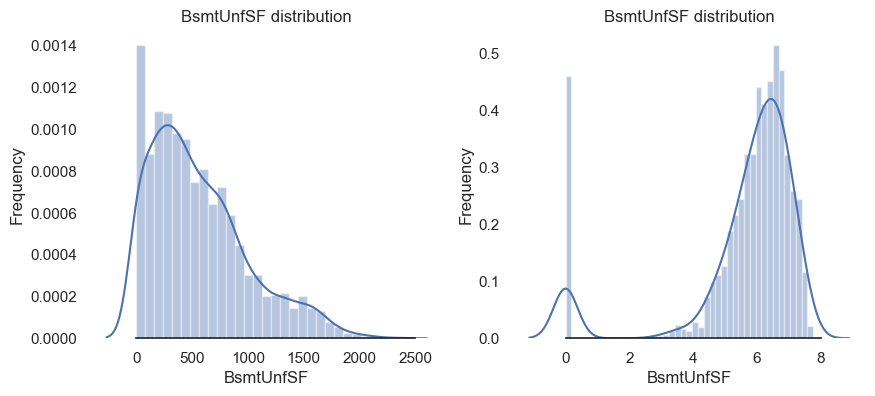

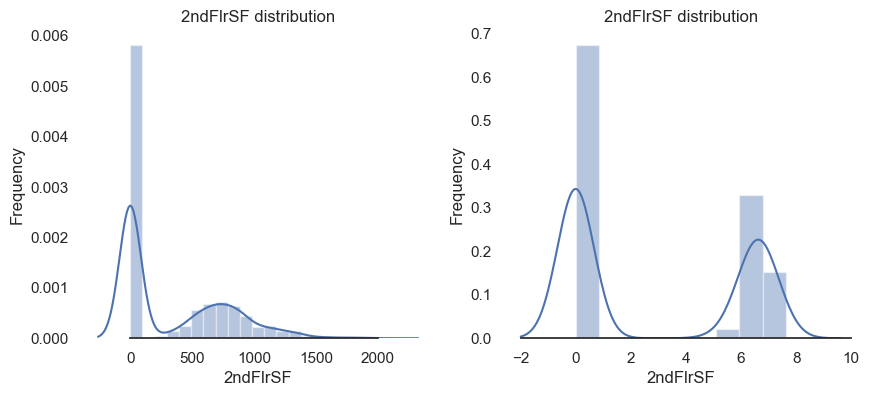

In [54]:
for i in skew_features.index:
  f, axes = plt.subplots(1,2,figsize=(10, 4))

  sns.distplot(all_features[i], color="b",ax=axes[0]);
  #axes[0].grid(False)
  axes[0].set(ylabel="Frequency")
  axes[0].set(xlabel=i)
  axes[0].set(title=i+" distribution")

  sns.distplot(np.log1p(all_features[i]), color="b",ax=axes[1]);
  #axes[0].grid(False)
  axes[1].set(ylabel="Frequency")
  axes[1].set(xlabel=i)
  axes[1].set(title=i+" distribution")

  sns.despine(trim=True, left=True)
plt.show()

Now let's start fixing our skewed features by applying log transformation on all of them.

In [55]:
for i in skew_features.index:
    all_features[i]=np.log1p(all_features[i])

# Finishing up the data

## Remove unnecessary columns

The Id columns is not a feature of the house, therefore we have to drop it.

In [56]:
id = all_features['Id'].copy()
all_features = all_features.drop(['Id'], axis=1)

We can view how our data look like after processing.

In [57]:
all_features.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,4.189655,9.042040,Pave,None,Reg,Lvl,AllPub,Inside,...,0.0,0.0,None,None,None,0.0,2,2008,WD,Normal
1,20,RL,4.394449,9.169623,Pave,None,Reg,Lvl,AllPub,FR2,...,0.0,0.0,None,None,None,0.0,5,2007,WD,Normal
2,60,RL,4.234107,9.328212,Pave,None,IR1,Lvl,AllPub,Inside,...,0.0,0.0,None,None,None,0.0,9,2008,WD,Normal
3,70,RL,4.110874,9.164401,Pave,None,IR1,Lvl,AllPub,Corner,...,0.0,0.0,None,None,None,0.0,2,2006,WD,Abnorml
4,60,RL,4.442651,9.565284,Pave,None,IR1,Lvl,AllPub,FR2,...,0.0,0.0,None,None,None,0.0,12,2008,WD,Normal


Check the shape of our data

In [58]:
all_features.shape

(2917, 79)

## One hot encoding
One hot encode categorical features.

In [59]:
all_features = pd.get_dummies(all_features).reset_index(drop=True)


In [60]:
all_features.insert(0,'Id',id)

In [61]:
all_features.head()

,Id,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,4.189655,9.042040,7,5,2003,2003,5.283204,6.561031,0.0,...,0,0,0,1,0,0,0,0,1,0
1,2,4.394449,9.169623,6,8,1976,1976,0.000000,6.886532,0.0,...,0,0,0,1,0,0,0,0,1,0
2,3,4.234107,9.328212,7,5,2001,2002,5.093750,6.188264,0.0,...,0,0,0,1,0,0,0,0,1,0
3,4,4.110874,9.164401,7,5,1915,1970,0.000000,5.379897,0.0,...,0,0,0,1,1,0,0,0,0,0
4,5,4.442651,9.565284,8,5,2000,2000,5.860786,6.486161,0.0,...,0,0,0,1,0,0,0,0,1,0


Finally, check for duplicated columns

In [62]:
#Check duplicated columns
all_features.columns.duplicated().sum()

0

# Data splitting

X: Our trainning set.

X_test: Use for final prediction.

In [63]:
X = all_features.iloc[:len(train_labels), :]
X_test = all_features.iloc[len(train_labels):, :]
X.shape, train_labels.shape, X_test.shape

((1458, 317), (1458,), (1459, 317))

save file for using to test model on web app


In [64]:
X_test.to_csv('hp_test.csv', index=False)
X.to_csv('hp_train.csv', index=False)

then drop id column on train and test file to fit model


In [65]:
all_features = all_features.drop(['Id'], axis=1)
X = all_features.iloc[:len(train_labels), :]
X_test = all_features.iloc[len(train_labels):, :]
X.shape, train_labels.shape, X_test.shape

((1458, 316), (1458,), (1459, 316))

# KFold

We will use Kfold to evaluate our models. It helps avoid our model overfitting on training set.

In [66]:
kf = KFold(n_splits=10, random_state=42, shuffle=True)

Define our error metric. Which is root mean squared error.

In [67]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, train_labels, scoring="neg_mean_squared_error", cv=kf,verbose=3,n_jobs=4))
    return (rmse)

# Machine learning models
The list of models we will train our data on:

* Light Gradient Boosting
* XGBoost
* Gradient Boosting Regressor
* Random Forest Regressor
* Ridge
* Lasso

These machine learning models can be like a black box. With some trials and errors, we can find a good set of hyperparameters, which have the lowest rmse.

After that, we will put these models into the ensemble model to improve the performance.

## Light Gradient Boosting

In [68]:
lightgbm=LGBMRegressor(feature_fraction=0.2, learning_rate=0.1,
              max_bin=100,min_data_in_bin=6, min_split_gain=0.0,
              min_sum_hessian_in_leaf=1, n_estimators=200,
              num_leaves=16, silent=True, subsample=0.7)
scores ={}
score = cv_rmse(lightgbm)
print("lightgbm: {:.6f} ({:.6f})".format(score.mean(), score.std()))
scores['lgb'] = (score.mean(), score.std())

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:    4.1s remaining:    1.7s


lightgbm: 0.117462 (0.015233)


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    4.4s finished


## Extreme Gradient Boosting (XGBoost)

In [69]:
xgb=XGBRegressor(objective ='reg:linear',verbosity = 0,random_state=42,learning_rate=0.1,subsample=1,colsample_bytree=1,
                 n_estimators=400,reg_alpha=0, reg_lambda=0.8)
score = cv_rmse(xgb)
print("xgboost: {:.6f} ({:.6f})".format(score.mean(), score.std()))
scores['xgb'] = (score.mean(), score.std())

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:   16.7s remaining:    7.1s


xgboost: 0.121988 (0.014561)


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:   22.4s finished


## Gradient Boosting

In [70]:
gbr=GradientBoostingRegressor(random_state=42,learning_rate=0.2,min_samples_split=5,
                              min_samples_leaf=3,
                              n_estimators=200,
                              loss='huber',)
score = cv_rmse(gbr)
print("gbr: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['gbr'] = (score.mean(), score.std())

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:    8.0s remaining:    3.4s


gbr: 0.1184 (0.0142)


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:   11.0s finished


## Support Vector Regression (SVR)

In [71]:
# svr=make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003))

# score = cv_rmse(svr)
# print("SVR: {:.4f} ({:.4f})".format(score.mean(), score.std()))
# scores['svr'] = (score.mean(), score.std())

## Elastic Net Regression (ENet)

In [72]:
# ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=1))
# score=cv_rmse(ENet)
# print("Enet: {:.6f} ({:.6f})".format(score.mean(), score.std()))
# scores['enet'] = (score.mean(), score.std())

## Random Forest Regressor (RF)

In [73]:
rf = RandomForestRegressor(max_depth = 10, random_state=42, n_estimators=200)

score = cv_rmse(rf)
print("randomforest: {:.6f} ({:.6f})".format(score.mean(), score.std()))
scores['rf'] = (score.mean(), score.std())

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:   18.4s remaining:    7.8s


randomforest: 0.137890 (0.013495)


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:   24.6s finished


## Ridge Regression

In [74]:
ridge_alphas = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5]
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alphas, cv=kf))
score = cv_rmse(ridge)
print("ridge: {:.6f} ({:.6f})".format(score.mean(), score.std()))
scores['ridge'] = (score.mean(), score.std())

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:   12.5s remaining:    5.3s


ridge: 0.110199 (0.015123)


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:   15.9s finished


## Lasso Regression

In [75]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =5e-4, random_state=42))
score=cv_rmse(lasso)
print("lasso: {:.6f} ({:.6f})".format(score.mean(), score.std()))
scores['lasso'] = (score.mean(), score.std())

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.6s finished


lasso: 0.108083 (0.015325)


After training all models, we can check how they performed.

In [76]:
df_score=pd.DataFrame.from_dict(scores,orient='index',columns=['rmse','std'])
df_score=df_score.rename_axis('model').reset_index()
df_score

,model,rmse,std
0,lgb,0.117462,0.015233
1,xgb,0.121988,0.014561
2,gbr,0.118378,0.014204
3,rf,0.137890,0.013495
4,ridge,0.110199,0.015123
5,lasso,0.108083,0.015325


Visualizing using columns for better comparison.

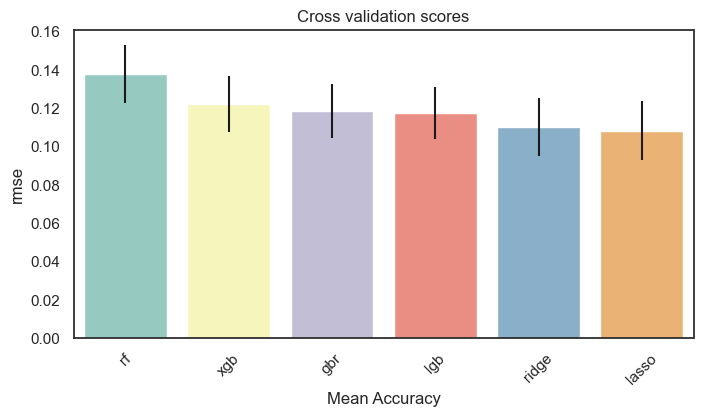

In [77]:
f, ax = plt.subplots(figsize=(8, 4))
g = sns.barplot(x= 'model',y= 'rmse',data = df_score.sort_values(by='rmse',ascending=False), palette="Set3",yerr=df_score['std'],orient="v")
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")
plt.xticks(rotation=45)
plt.show()

ENet currently has the best performance while gbr is the worst. The top 4 models have significantly lower errors than the others.

# Ensemble learning

Stacking is a good way to boost the model performance. 

In [78]:
# Put all model into estimators
estimators = [('gbr', lightgbm),
             ('xgb',xgb),
              ('RF',rf),
              ('lasso',lasso),
              ('ridge',ridge),
              ('gb',gbr)]

## Ensemble voting regressor

In [79]:
voting_reg = VotingRegressor(estimators=estimators)
voting_cv=cv_rmse(voting_reg)
scores['voting'] = (voting_cv.mean(), voting_cv.std())

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:  1.0min remaining:   26.2s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:  1.3min finished


## Ensemble stacking regressor

In [80]:
stacking_reg=StackingRegressor(estimators=estimators,final_estimator=Ridge(2))
stacking_cv=cv_rmse(stacking_reg)
scores['stacking'] = (stacking_cv.mean(), stacking_cv.std())

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:  6.2min remaining:  2.6min
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:  7.8min finished


Comparing our ensemble models

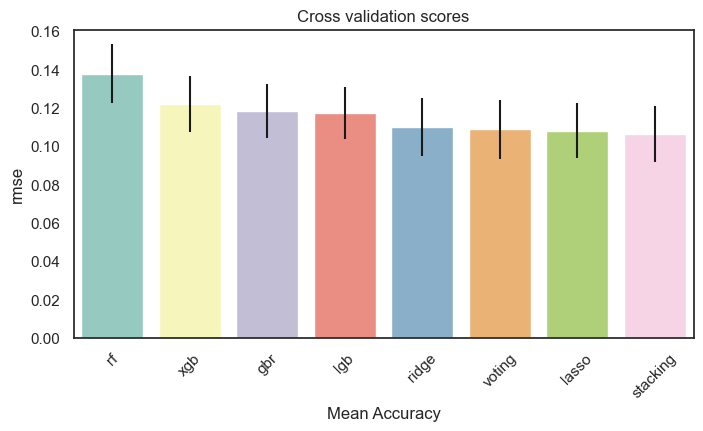

In [81]:
df_score=pd.DataFrame.from_dict(scores,orient='index',columns=['rmse','std'])
df_score=df_score.rename_axis('model').reset_index()
f, ax = plt.subplots(figsize=(8, 4))
g = sns.barplot(x = 'model',y = 'rmse',data = df_score.sort_values(by='rmse',ascending=False), palette="Set3",yerr=df_score['std'],orient="v")
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")
plt.xticks(rotation=45)
plt.show()

As we can see StackingRegressor have a lowest error and we will choose this as the best model.

# Making prediction

Having chosen StackingRegressor as the final model, we start trainning the model on our dataset.

In [82]:
X_train,X_test,y_train,y_test = train_test_split(X,train_labels,test_size=0.1,random_state=42)

In [83]:
lightgbm.fit(X_train,y_train)
pred_test = lightgbm.predict(X_test)
print(rmsle(pred_test,y_test))
#save weight
with open ('lgb.pkl','wb') as lgb_pkl:
  pickle.dump(lightgbm,lgb_pkl)
  #load model
with open('lgb.pkl','rb') as lgb_pkl:
  lgb = pickle.load(lgb_pkl)

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
0.10866226663299577


In [84]:
xgb.fit(X_train,y_train)
pred_test = xgb.predict(X_test)
print(rmsle(pred_test,y_test))
#save weight
with open ('xgb.pkl','wb') as xgb_pkl:
  pickle.dump(xgb,xgb_pkl)
  #load model
with open('xgb.pkl','rb') as xgb_pkl:
  xgb = pickle.load(xgb_pkl)


0.11146667016692137


In [85]:
gbr.fit(X_train,y_train)
pred_test = gbr.predict(X_test)
print(rmsle(pred_test,y_test))
#save weight
with open ('gbr.pkl','wb') as gbr_pkl:
  pickle.dump(gbr,gbr_pkl)
  #load model
with open('gbr.pkl','rb') as gbr_pkl:
  gbr = pickle.load(gbr_pkl)

0.09228590031539621


In [86]:
# svr.fit(X,train_labels)
# #save weight
# with open ('svr.pkl','wb') as svr_pkl:
#   pickle.dump(svr,svr_pkl)
#   #load model
# with open('svr.pkl','rb') as svr_pkl:
#   svr = pickle.load(svr_pkl)

In [87]:
# ENet.fit(X,train_labels)
# #save weight
# with open ('enet.pkl','wb') as enet_pkl:
#   pickle.dump(ENet,enet_pkl)
#   #load model
# with open('enet.pkl','rb') as enet_pkl:
#   enet = pickle.load(enet_pkl)

In [88]:
ridge.fit(X_train,y_train)
pred_test = ridge.predict(X_test)
print(rmsle(pred_test,y_test))
#save weight
with open ('ridge.pkl','wb') as ridge_pkl:
  pickle.dump(ridge,ridge_pkl)
  #load model
with open('ridge.pkl','rb') as ridge_pkl:
  ridge = pickle.load(ridge_pkl)

0.0888104332144038


In [89]:
lasso.fit(X_train,y_train)
pred_test = lasso.predict(X_test)
print(rmsle(pred_test,y_test))
#save weight
with open ('lasso.pkl','wb') as lasso_pkl:
  pickle.dump(lasso,lasso_pkl)
  #load model
with open('lasso.pkl','rb') as lasso_pkl:
  lasso = pickle.load(lasso_pkl)

0.08294850268855938


In [90]:
rf.fit(X_train,y_train)
pred_test = rf.predict(X_test)
print(rmsle(pred_test,y_test))
#save weight
with open ('rf.pkl','wb') as rf_pkl:
  pickle.dump(rf,rf_pkl)
  #load model
with open('rf.pkl','rb') as rf_pkl:
  rf = pickle.load(rf_pkl)

0.1328618421418312


In [91]:
voting_reg.fit(X_train,y_train)
pred_test = voting_reg.predict(X_test)
print(rmsle(pred_test,y_test))
#save weight
with open ('voting.pkl','wb') as voting_pkl:
  pickle.dump(voting_reg,voting_pkl)
  #load model
with open('voting.pkl','rb') as voting_pkl:
  voting = pickle.load(voting_pkl)

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
0.09291820887477693


In [92]:
stacking_reg=StackingRegressor(estimators=estimators,final_estimator=Ridge(alpha=2))
stacking_reg.fit(X_train,y_train)
pred_test = stacking_reg.predict(X_test)
print(rmsle(pred_test,y_test))

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. C

In [93]:
#save weight
with open ('stacking.pkl','wb') as stacking_pkl:
  pickle.dump(stacking_reg,stacking_pkl)
#load model
with open('stacking.pkl','rb') as stacking_pkl:
  stacking = pickle.load(stacking_pkl)

In [94]:
# Make prediction
y_pred_s=stacking.predict(X)

# Rmse
rmsle(train_labels,y_pred_s)

0.07392794602853378

Error on training set

In [95]:
# Make prediction
y_pred=stacking_reg.predict(X)

# Rmse
rmsle(train_labels,y_pred)

0.07392794602853378

Our training  set have rmse of about 0.07. Which is pretty good.

# Submission

Make predictions on the test set and use np.expm1 to cancel out the log transformation we did before.

In [96]:
y_pred=stacking_reg.predict(X_test)
y_pred=np.expm1(y_pred)

Make .csv file as our final result

In [97]:
df=pd.DataFrame({'SalePrice':y_pred})
df.index+=1461
df.reset_index(inplace=True)
df.rename({'index':'Id'},inplace=True,axis=1)
# df.to_csv('result.csv',index=False)

df

,Id,SalePrice
0,1461,227796.002803
1,1462,97258.676156
2,1463,103524.598118
3,1464,160319.318494
4,1465,329264.487111
...,...,...
141,1602,439798.335864
142,1603,169747.847003
143,1604,123915.506607
144,1605,136139.518387
